<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/04_transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer Learing is leveraging a working model's existing architecture and learned patterns for our own problem

Why use transfer learning?
* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in great results with less data).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*

In [1]:
# Are we using a GPU
!nvidia-smi

Thu Aug 10 19:29:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-10 19:29:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.6MB/s    in 4.6s    

2023-08-10 19:29:31 (34.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through data directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wing

We get 10 times less examples in train data for our model to learn.

## Create data loaders (preparing the data)

Use `ImageDataGenerator`

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameter:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE)
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback (It is important when we run many models and we need to compare the performance of each of them)
* Model checkpoint with the ModelCheckpoint callback (when we run, say, 1000 epochs, we can set a checkpoint to our model performance/results)
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
 # Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  '''
  dir_name - where to store the model results
  experiment_name -  name of this experiment
  '''
  log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tnesorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

TensorFlow Hub is a repository of trained machine learning models
`import tensorflow_hub as hub`

In the past we used TnesorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, excpt the ,ajoruty of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

> TensorFlow Hub makes using a pre-trained model as simple as calling a URL

**⭐️Tips:** When you're working on any different kind of deep learning problem, you can browse on **TensorFlow Hub** to see "*Does my problem exist on TensorFlow Hub?*"

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) - a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: [efficientnet_b0](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)
and [resnet_v2_50](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)


In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [74]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extrator,
    layer and Sense ouput layer with num_classes output neurons
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the already learned patterns
                                           name="feature_keras_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  if num_classes > 2:
    out_put_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')
  else:
    out_put_layer = layers.Dense(1, activation='sigmoid', name='output_layer')

  model = tf.keras.Sequential([
      feature_extractor_layer,
      out_put_layer
  ])

  return model

### Creating and testing ResNet TensorFlow Hub

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [10]:
# feature extractor layer is not trainable, the only tranable parameters are in output layer
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_keras_layer (KerasL  (None, 2048)             23564800  
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
resnet_history = resnet_model.fit(train_data, epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                        experiment_name="resnet50v2")],
                 validation_steps=len(test_data)
                 )

Saving Tnesorboard log files to: tensorflow_hub/resnet50v2/20230810-192946
Epoch 1/5
24/24 [==============================] - 35s 670ms/step - loss: 1.7841 - accuracy: 0.4360 - val_loss: 1.1724 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 11s 474ms/step - loss: 0.8457 - accuracy: 0.7600 - val_loss: 0.8305 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 11s 464ms/step - loss: 0.5870 - accuracy: 0.8427 - val_loss: 0.7660 - val_accuracy: 0.7508
Epoch 4/5
24/24 [==============================] - 12s 523ms/step - loss: 0.4513 - accuracy: 0.8787 - val_loss: 0.7137 - val_accuracy: 0.7620
Epoch 5/5
24/24 [==============================] - 11s 478ms/step - loss: 0.3610 - accuracy: 0.9160 - val_loss: 0.6809 - val_accuracy: 0.7760


That is a incredible result. Our transfer learning feature extractor model out performed ALL of th eprevious models we built. It is quicker training time and with only 10% of the training examples.

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves(history):

  history = pd.DataFrame(history.history)
  loss = history[['loss', 'val_loss']]
  accuracy = history[['accuracy','val_accuracy']]

  epochs = range(history.shape[0])
  # Plot loss curves
  plt.figure()
  plt.plot(epochs, loss, label=['loss', 'val_loss'])
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend();

  # Plot accuracy curves
  plt.figure()
  plt.plot(epochs, accuracy, label=['accuracy', 'val_accuracy'])
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

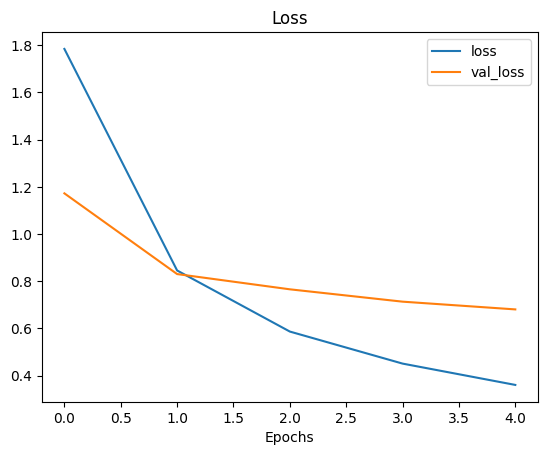

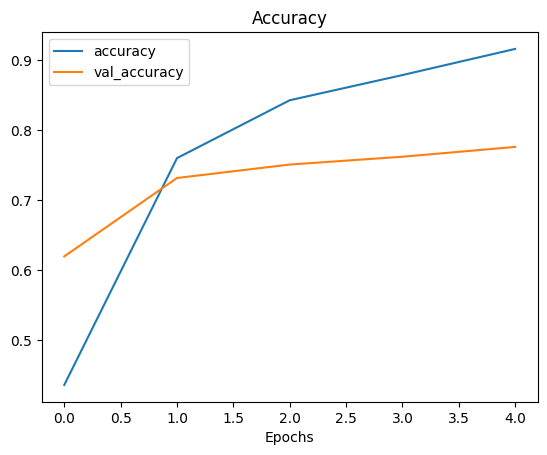

In [14]:
plot_loss_curves(resnet_history)
# resnet_history.history

### Creating and testing EfficientNetB0 from TensorFlow Hub feature extraction model

In [15]:
efficient_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [16]:
# Compile
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [17]:
# Fie the efficientnet_model
efficient_history = efficient_model.fit(train_data, epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback('tensorflow_hub','efficientnetb0')])

Saving Tnesorboard log files to: tensorflow_hub/efficientnetb0/20230810-193137
Epoch 1/5
24/24 [==============================] - 24s 535ms/step - loss: 1.8182 - accuracy: 0.4760 - val_loss: 1.2689 - val_accuracy: 0.7652
Epoch 2/5
24/24 [==============================] - 11s 467ms/step - loss: 1.0569 - accuracy: 0.7947 - val_loss: 0.8494 - val_accuracy: 0.8300
Epoch 3/5
24/24 [==============================] - 10s 410ms/step - loss: 0.7523 - accuracy: 0.8453 - val_loss: 0.6890 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 13s 575ms/step - loss: 0.6058 - accuracy: 0.8693 - val_loss: 0.6020 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 10s 430ms/step - loss: 0.5122 - accuracy: 0.8920 - val_loss: 0.5495 - val_accuracy: 0.8660


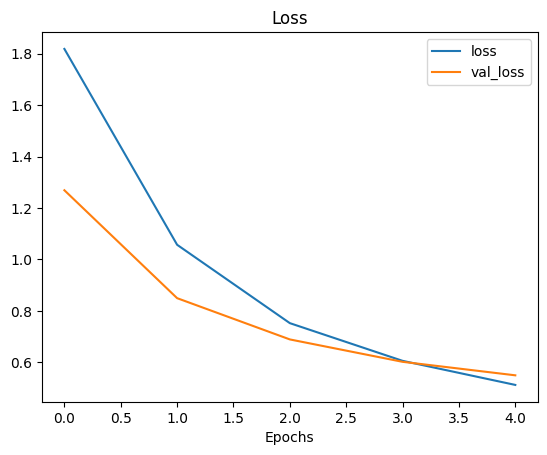

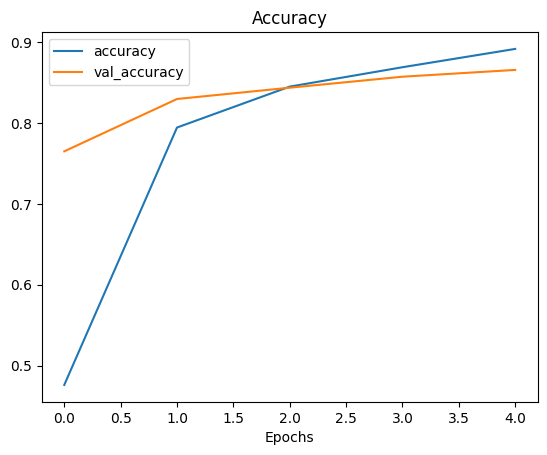

In [18]:
plot_loss_curves(efficient_history)

In [19]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_keras_layer (KerasL  (None, 1280)             4049564   
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Amazing! Apparantly, the EfficientNetB0 beats the ResNet50v2. And EfficientNetB0 has less total params than Resnet50v2.

In [ ]:
# How many layers does our efficientb0 feature extractor have?
len(efficient_model.layers[0].weights)

309

## Different type of transfer learning

* **"As is" transfer learning** - use an existing model with no changes (e.g using ImageNet model on 1000 ImageNet Classes)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output lyer for your own problem.
* **"Fine-tuning" transfer learning** - use the prelearned patterns od an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

## Comparing our model results using TensorBoard

### What is TensorBoard?
A way to visually explore your machine learning models performance and internals. You can host, track and share your machine learning experiment on [TensorBoard.dev](https://tensorboard.dev/)

>**Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiment (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub Feature extraction model architectures using 10% of the training data" \
--one_shot

2023-08-07 18:39:13.224541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   BMDN-QBML



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

Our TensorBoard experiment are upload publically on https://tensorboard.dev/experiment/aJUqjNfOTdmzOI6Ve0HR1Q/

In [ ]:
# Check our what TensorBoard experiments you have
!tensorboard dev list

2023-08-07 18:44:29.459956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/aJUqjNfOTdmzOI6Ve0HR1Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature extraction model architectures using 10% of the training data
	Id                   aJUqjNfOTdmzOI6Ve0HR1Q
	Created              2023-08-07 18:40:28 (4 minutes ago)
	Updated              2023-08-07 18:40:32 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5798214
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id

In [ ]:
# Confirm the deletion by re-checking what experiment you have left

# Transfer Learning Part 1: Feature Extraction Exercise


## Exercise 1
Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5)) from TensorFlow Hub, how does it perform compared to our other models?

In [20]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 13s 159ms/step - loss: 0.6809 - accuracy: 0.7760


[0.6808594465255737, 0.7760000228881836]

In [21]:
efficient_model.evaluate(test_data)

79/79 [==============================] - 10s 128ms/step - loss: 0.5495 - accuracy: 0.8660


[0.5494831204414368, 0.8659999966621399]

In [22]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

mobilenet_model = create_model(mobilenet_url, num_classes=10)

In [23]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_keras_layer (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_keras_layer (KerasL  (None, 1280)             4049564   
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [26]:
mobilenet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [29]:
mobilenet_model.fit(train_data, epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                          experiment_name='mobilenetv2')])


Saving Tnesorboard log files to: tensorflow_hub/mobilenetv2/20230810-193818
Epoch 1/5
24/24 [==============================] - 28s 968ms/step - loss: 1.8110 - accuracy: 0.4240 - val_loss: 1.2588 - val_accuracy: 0.6496
Epoch 2/5
24/24 [==============================] - 10s 415ms/step - loss: 1.0149 - accuracy: 0.7107 - val_loss: 0.8509 - val_accuracy: 0.7496
Epoch 3/5
24/24 [==============================] - 12s 496ms/step - loss: 0.7028 - accuracy: 0.8120 - val_loss: 0.7490 - val_accuracy: 0.7704
Epoch 4/5
24/24 [==============================] - 10s 416ms/step - loss: 0.5643 - accuracy: 0.8573 - val_loss: 0.7030 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 9s 390ms/step - loss: 0.4807 - accuracy: 0.8827 - val_loss: 0.6527 - val_accuracy: 0.7956


In [30]:
mobilenet_model.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.6527 - accuracy: 0.7956


[0.6526913046836853, 0.7955999970436096]

**Conclusion:** The performances of three models from TensorFlow Hub is: EfficientNetB0 > MobileNetV2 > ResNet50V2.

## Exercise 2
Name 3 different image classification models on TensorFlow Hub that we haven't used.

1. [RegNetY](https://tfhub.dev/adityakane2001/regnety400mf_feature_extractor/1)
2. [Inception](https://tfhub.dev/google/imagenet/inception_v3/classification/5)
3. [NASNet-A](https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/5)

## Exercise 3
What is the current best performing model on ImageNet?

### Info get from [paper with code - Image Classification](https://paperswithcode.com/task/image-classification)

**Image Classification** is a fundamental task in vision recognition that aims to understand and categorize an image as a whole under a specific label.

The best model for **ImageNet** so far is BASIC-L.
* [paper and code](https://paperswithcode.com/paper/symbolic-discovery-of-optimization-algorithms#code)

# Play Around
Source:https://www.tensorflow.org/tutorials/images/transfer_learning


## Use model trained above to classify cats and dogs

How to get images?  
URL: 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'


In [31]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 2s 0us/step


In [32]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'validation')

In [33]:
# Walk through data directory
for dirpath, dirnames, filenames in os.walk(PATH):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 1 images in '/root/.keras/datasets/cats_and_dogs_filtered'
There are 2 directories and 0 images in '/root/.keras/datasets/cats_and_dogs_filtered/train'
There are 0 directories and 1000 images in '/root/.keras/datasets/cats_and_dogs_filtered/train/dogs'
There are 0 directories and 1000 images in '/root/.keras/datasets/cats_and_dogs_filtered/train/cats'
There are 2 directories and 0 images in '/root/.keras/datasets/cats_and_dogs_filtered/validation'
There are 0 directories and 500 images in '/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs'
There are 0 directories and 500 images in '/root/.keras/datasets/cats_and_dogs_filtered/validation/cats'


train file has 1000 images for dogs and cats respectively.

test file has 500 images for dogs and cats respectively

In [64]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode="binary")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


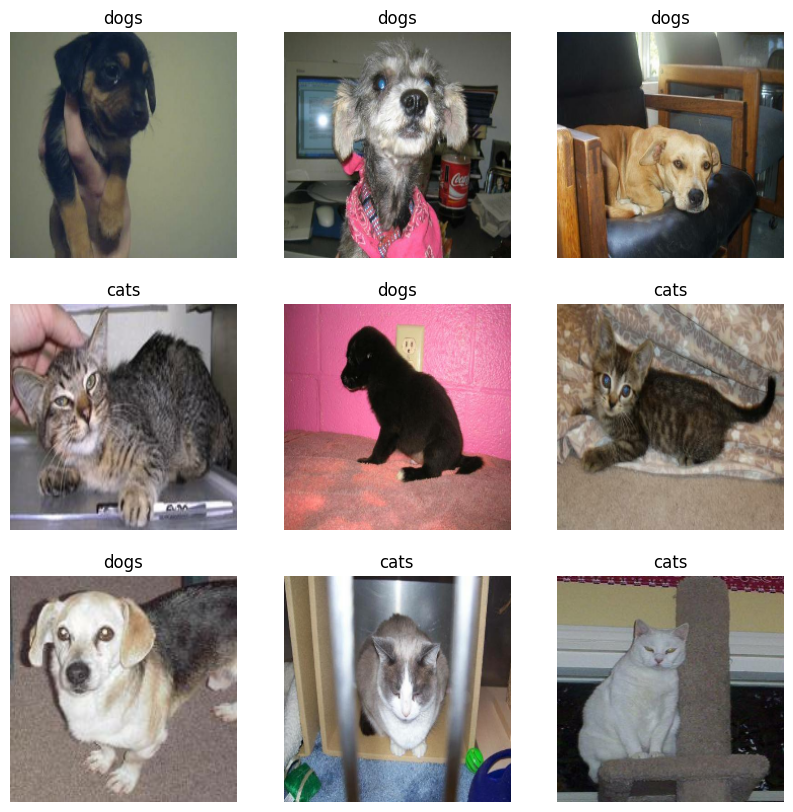

In [54]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [55]:
# Use data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2)
])

## Recreate model, compile and fit

> ⚠️ You need to recreate and compile model from model url here, cuz model above was imported for 10 classes.

In [75]:
efficient_model = create_model(efficientnet_url, num_classes=2)
resnet_model = create_model(resnet_url, num_classes=2)
mobilenet_model = create_model(mobilenet_url, num_classes=2)

In [76]:
efficient_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])
resnet_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])
mobilenet_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [77]:
efficient_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_keras_layer (KerasL  (None, 1280)             4049564   
 ayer)                                                           
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [78]:
efficient_hist = efficient_model.fit(train_data,
                                      epochs=8,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.5*len(test_data)))


Epoch 1/8
63/63 [==============================] - 16s 109ms/step - loss: 212.5736 - accuracy: 0.5055 - val_loss: 192.4845 - val_accuracy: 0.5156
Epoch 2/8
63/63 [==============================] - 5s 80ms/step - loss: 145.1736 - accuracy: 0.5290 - val_loss: 181.6318 - val_accuracy: 0.5059
Epoch 3/8
63/63 [==============================] - 5s 81ms/step - loss: 128.0767 - accuracy: 0.5455 - val_loss: 149.4470 - val_accuracy: 0.5273
Epoch 4/8
63/63 [==============================] - 6s 91ms/step - loss: 94.3197 - accuracy: 0.5660 - val_loss: 168.7671 - val_accuracy: 0.5312
Epoch 5/8
63/63 [==============================] - 6s 95ms/step - loss: 98.6342 - accuracy: 0.5715 - val_loss: 146.8778 - val_accuracy: 0.5039
Epoch 6/8
63/63 [==============================] - 6s 92ms/step - loss: 98.1963 - accuracy: 0.5765 - val_loss: 150.2402 - val_accuracy: 0.5156
Epoch 7/8
63/63 [==============================] - 5s 81ms/step - loss: 75.1661 - accuracy: 0.5885 - val_loss: 125.2914 - val_accuracy: 0

In [58]:
resnet_hist = resnet_model.fit(train_data,
                              epochs=8,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.5*len(test_data)))


Epoch 1/8
63/63 [==============================] - 10s 152ms/step - loss: 406.8285 - accuracy: 0.0825 - val_loss: 280.0448 - val_accuracy: 0.0215
Epoch 2/8
63/63 [==============================] - 10s 148ms/step - loss: 261.9790 - accuracy: 0.0810 - val_loss: 241.5723 - val_accuracy: 0.0664
Epoch 3/8
63/63 [==============================] - 9s 137ms/step - loss: 239.4134 - accuracy: 0.0885 - val_loss: 227.0798 - val_accuracy: 0.0684
Epoch 4/8
63/63 [==============================] - 12s 179ms/step - loss: 228.6176 - accuracy: 0.0910 - val_loss: 242.9067 - val_accuracy: 0.0547
Epoch 5/8
63/63 [==============================] - 8s 118ms/step - loss: 221.1469 - accuracy: 0.0895 - val_loss: 224.6058 - val_accuracy: 0.0586
Epoch 6/8
63/63 [==============================] - 11s 163ms/step - loss: 215.2033 - accuracy: 0.0925 - val_loss: 208.4730 - val_accuracy: 0.0703
Epoch 7/8
63/63 [==============================] - 9s 129ms/step - loss: 207.4704 - accuracy: 0.0945 - val_loss: 199.2771 - va

In [59]:
mobilenet_hist = mobilenet_model.fit(train_data,
                                      epochs=8,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.5*len(test_data)))

Epoch 1/8
63/63 [==============================] - 5s 71ms/step - loss: 14.2367 - accuracy: 0.0095 - val_loss: 14.0268 - val_accuracy: 0.0117
Epoch 2/8
63/63 [==============================] - 5s 70ms/step - loss: 13.6331 - accuracy: 0.0225 - val_loss: 14.2731 - val_accuracy: 0.0195
Epoch 3/8
63/63 [==============================] - 6s 88ms/step - loss: 13.6072 - accuracy: 0.0250 - val_loss: 13.9912 - val_accuracy: 0.0156
Epoch 4/8
63/63 [==============================] - 5s 69ms/step - loss: 13.5838 - accuracy: 0.0245 - val_loss: 14.0800 - val_accuracy: 0.0234
Epoch 5/8
63/63 [==============================] - 6s 97ms/step - loss: 13.5263 - accuracy: 0.0260 - val_loss: 13.8933 - val_accuracy: 0.0176
Epoch 6/8
63/63 [==============================] - 5s 67ms/step - loss: 13.5362 - accuracy: 0.0275 - val_loss: 13.8305 - val_accuracy: 0.0273
Epoch 7/8
63/63 [==============================] - 5s 70ms/step - loss: 13.4986 - accuracy: 0.0295 - val_loss: 13.7897 - val_accuracy: 0.0234
Epoch 

In [60]:
print(f"Val accuracy of efficientnet model: {efficient_model.evaluate(test_data)}")
print(f"Val accuracy of resnet model: {resnet_model.evaluate(test_data)}")
print(f"Val accuracy of mobilenet model: {mobilenet_model.evaluate(test_data)}")

32/32 [==============================] - 3s 78ms/step - loss: 4242.9590 - accuracy: 0.1110
Val accuracy of efficientnet model: [4242.958984375, 0.11100000143051147]
32/32 [==============================] - 4s 119ms/step - loss: 198.7595 - accuracy: 0.0810
Val accuracy of resnet model: [198.75949096679688, 0.08100000023841858]
32/32 [==============================] - 2s 57ms/step - loss: 13.6489 - accuracy: 0.0250
Val accuracy of mobilenet model: [13.648877143859863, 0.02500000037252903]


> Comments: Suprisingly, none of these three models get a good result for cats and dogs image classification. I wonder why....

In [81]:
efficient_history.history['loss']

[1.8182475566864014,
 1.0569355487823486,
 0.752278745174408,
 0.6057764291763306,
 0.5121587514877319]

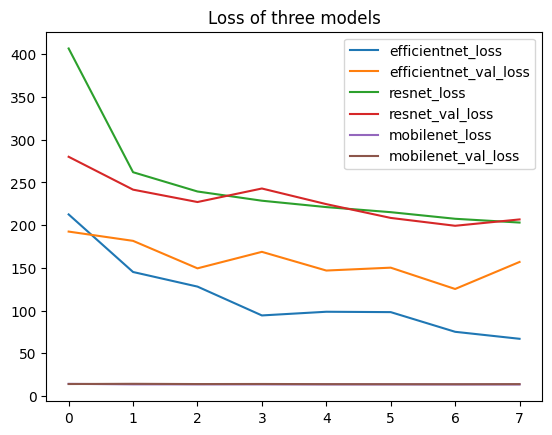

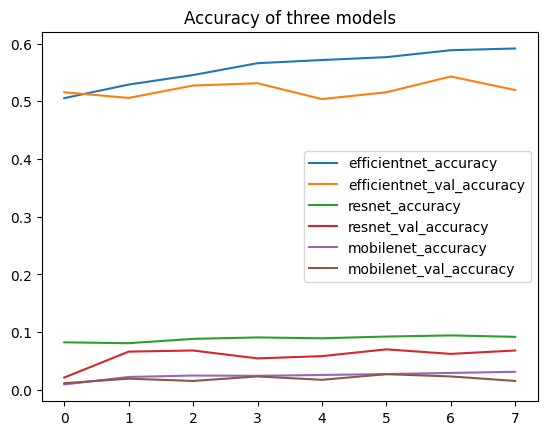

In [87]:
from unicodedata import name
# Plot loss curve of three models
epochs = range(8)
plt.plot(epochs, efficient_hist.history['loss'], label="efficientnet_loss")
plt.plot(epochs, efficient_hist.history['val_loss'] , label="efficientnet_val_loss")
plt.plot(epochs, resnet_hist.history['loss'], label="resnet_loss")
plt.plot(epochs, resnet_hist.history['val_loss'], label="resnet_val_loss" )
plt.plot(epochs, mobilenet_hist.history['loss'], label="mobilenet_loss" )
plt.plot(epochs, mobilenet_hist.history['val_loss'], label="mobilenet_val_loss" )
plt.title("Loss of three models")
plt.legend()

plt.figure()
plt.plot(epochs, efficient_hist.history['accuracy'], label="efficientnet_accuracy")
plt.plot(epochs, efficient_hist.history['val_accuracy'] , label="efficientnet_val_accuracy")
plt.plot(epochs, resnet_hist.history['accuracy'], label="resnet_accuracy")
plt.plot(epochs, resnet_hist.history['val_accuracy'], label="resnet_val_accuracy" )
plt.plot(epochs, mobilenet_hist.history['accuracy'], label="mobilenet_accuracy" )
plt.plot(epochs, mobilenet_hist.history['val_accuracy'], label="mobilenet_val_accuracy" )
plt.title("Accuracy of three models")
plt.legend()